## Implementing a GPT Model from Scratch to Generate Text ##

Bab ini memuat  
- Coding model llm seperti GPT untuk generate text
- Normalisasi aktivasi layer untuk stabilitas pelatihan NN
- Menambahkan koneksi pintasan pada DNN
- Implementasi transformers block untuk membuat model GPT dengan ukuran yang bervariasi
- Komputasi ukuran dari parameter dan penyimpanan yang dibutuhkan untuk model GPT

Diagram alur pada chapter ini  
1) GPT Backbone -> Membuat sebuah penampung GPT MOdel untuk melihat struktur model secara keseluruhan  
2) Layer Normalization   
3) GELU Activation  
4) Feed Forward Network  
5) Shortcut connections  
6) Transformers block  
7) Final architecture of GPT

### 4.1 Coding an LLM architecture

GPT *(Generative Pretrained Transformers)* adalah sebuah arsitektur large deep neutal network yang didesain untuk meng-generate teks baru (satu teks atau satu token pada satu waktu). Arsitektur model ini sebenarnya tidak terlalu kompleks, semenjak banyak komponen yang dilakukan berulang.  
GPT-2 Model (berdasar papernya) memiliki versi terkecil dengan **124 juta** parameters. 'Parameters' merujuk pada *trainable weights* atau bobot yang dapat dilatih pada model. Bobot ini pada dasarnya adalah variable internal yang akan disesuaikan dan dioptimasi selama proses pelatihan dengan tujuan untuk minimalisasi loss-function.

In [33]:
# GPT-2 Config
GPT_CONFIG_124M = {
    'vocab_size': 50257,        # Vocab size
    'context_length' : 1024,    # Context length - panjang token input
    'emb_dim' : 768,            # Embedding dimension
    'n_heads' : 12,             # Number of attention heads
    'n_layers' : 12,            # Number of layers
    'drop_rate' : 0.1,          # Dropout rate
    'qkv_bias' : False          # QKV Bias
}

- `vocab_size`      : merujuk pada banyaknya vocabulary yang digunakan pada tokenizer  
- `context_length`  : menunjukkan panjang maksimum dari input token yang bisa dihandle oleh model via positinal embedding  
- `emd_dim`         : menunjukkan ukuran dari embedding, pada kasus ini 768-dimensional vector  
- `n_heads`         : mengindikasi banyaknya attention-heads pada mekanisme multi-head attention  
- `n_layers`        : menentukan banyaknya transformer block  
- `drop_rate`       : mengindikasikan intensitas dari mekanisme dropout (0.1 = 10% hidden unit secara random akan didropout)  
- `qkv_bias`        : menentukan apakah bias vector pada linear layers ikut dikomputasi

In [34]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        # menyiapkan tempat untuk nantinya diisi transformers block
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        # menyiapkan final layer norm
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)

        logits = self.out_head(x)
        return logits
    

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x
# simple placeholder class, that will be replaced with the real transformer block


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps = 1e-5):
        super().__init__() 
        # the parameter mimic (meniru) LayerNorm
    def forward(self, x):
        return x
# simple placeholder class, that will be replaced with the real layer norm

In [35]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

batch = []
txt1 = 'Every efforts moves you'
txt2 = 'Every day holds a'

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 4040, 6100,  345],
        [6109, 1110, 6622,  257]])


Selanjutnya kita akan menginisialisasi 124-juta-parameter `DummyGPTModel`

In [36]:
torch.manual_seed(123)

model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)

print('Output shape : ', logits.shape)
print(logits)

Output shape :  torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.8606,  1.3502, -0.2798,  ..., -0.6376,  1.4690,  1.2530],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


Outputnya menghasilkan shape **(2, 4, 50257)** mengacu pada 2 sample teks. Setiap teks mengandung 4 tokens, setiap tokens adalag 50257-dimensional vector--sama dengan ukuran dari vocabulary.

50257 dimension karena setiap dimensi mengacu pada token unik di dalam vocabulary. Ketika mengimplementasikan postprocessing, kita akan mengkonversi kembali 50257-dimensional vector ini pada token IDs, kemudian decode.

### 4.2 Normalizing activations with layer normalization

Layer Normalization meningkatkan stabilitas dan efisiensi saat melatih neural network. Layer ini bertujuan untuk menyesuaikan output dari neural network untuk memiliki mean 0 dan variansi 1. Penyesuaian ini akan mempercepat konvergensi dan efektivitas bobot.

Pada GPT-2 dan model transformers modern lainnya umumnya meletakkan Layer Normalization sebelum dan sesudah multi-head attention module

In [37]:
torch.manual_seed(123)

batch_example = torch.rand(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)

print(out)

tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


Sebelum menerapkan Layer Normalization untuk output, mari mencari mean dan variansi

In [38]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print('Mean:\n', mean)
print('Variance:\n', var)

Mean:
 tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


In [39]:
out_norm = (out - mean) / torch.sqrt(var)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)

print('Output Normalized:\n', out_norm)
print('Mean:\n', mean)  
print('Variance:\n', var)

Output Normalized:
 tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [40]:
# improve readibility
torch.set_printoptions(sci_mode=False)
print('Mean : \n', mean)
print('Variance : \n', var)

Mean : 
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance : 
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [41]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        return self.scale * norm_x + self.shift

In [42]:
ln = LayerNorm(emb_dim=5)

out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print('Mean : \n', mean)
print("Var : \n", var)

Mean : 
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Var : 
 tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


### 4.3 Implementing a feed forward network with GELU activations

GELU >> Gaussian Eror Linear Unit

In [43]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

Comparing with ReLU (Rectified Linear Unit)

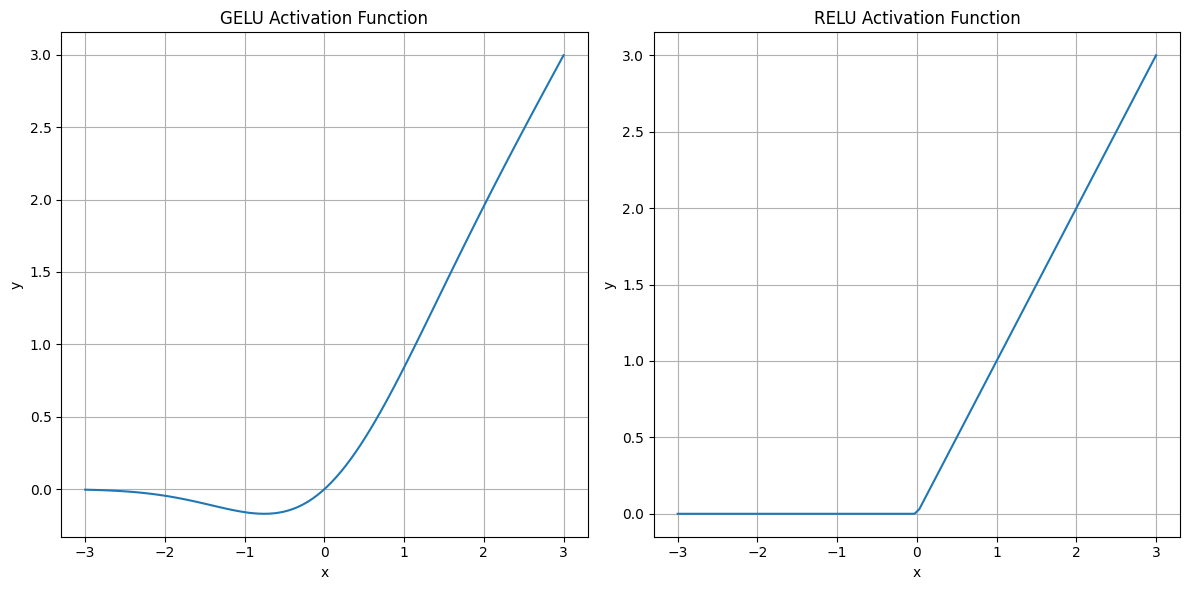

In [44]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)

y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(12, 6))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', 'RELU']), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} Activation Function")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
plt.tight_layout()
plt.show() 

GELU >> non-zero gradient for almost all negative values.  
- GELU dapat menerima berbagai nuansa penyesuaian pada parameter model  
- Sebaliknya RELU memiliki sudut yang tajam pada 0 yang dapat membuat proses optimasi berat  
- GELU menerima input yang kecil dan non-zero untuk nilai yang negatif  
- Dengan ini neuron yang menerima input negatif tetap bisa berkontribusi pada proses, meskipun lebih kecil daripada nilai positif

Selanjutnya, menggunakan GELU untuk modul `FeedForward` yang akan digunakan di Transformers block 

In [45]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )

    def forward(self, x):
        return self.layers(x)

In [46]:
ffn = FeedForward(GPT_CONFIG_124M)

x = torch.randn(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


### 4.4 Adding shortcut connections

Shortcut Connections disebut juga Skip Connections disebut juga Residual Connections adalah metode jalur pintas yang memungkinkan informasi untuk melewati satu atau beberapa lapisan (layer) dalam arsitektur jaringan saraf. Alih-alih informasi hanya mengalir secara berurutan dari satu lapisan ke lapisan berikutnya, skip connections menambahkan output dari lapisan sebelumnya langsung ke output dari lapisan yang lebih dalam.  
Output dari suatu sub-lapisan (misalnya, lapisan self-attention atau feed-forward) ditambahkan kembali ke input dari sub-lapisan tersebut.


- Mengatasi masalah Vanishing Gradient  
- Mempercepat konvergensi

In [47]:
# neural network to ilustrate shortcut connection

class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shorcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),GELU()),
        ])
        # implement five layers

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shorcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

Kelas diatas mengimplementasikan deep neural network dengan lima lapisan, setiap lapisan terdapat `linear` dan `GELU`. Pada forward pass, kita secara iteratif memasukkkan input ke setiap layers dan secara opsional menambahkan shortcut connections jika `self.use_shortcut` bernilai True.

In [48]:
# use_shortcut : False

layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

# for reproductibility
torch.manual_seed(123)

model_without_shorcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [49]:
# create function to computes the gradients in the models backward pass
def print_gradients(model, x):
    output = model(x)  # Forward pass
    target = torch.tensor([[0.]], device=x.device)  # Define a target
    loss = nn.MSELoss()(output, target)  # Compute loss
    loss.backward()  # Backward pass

    for name, param in model.named_parameters():
        if param.grad is not None and 'weight' in name:  # Check if grad exists
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
        else:
            print(f"{name} has no gradient")

# Example usage
print_gradients(model_without_shorcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.0.0.bias has no gradient
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.1.0.bias has no gradient
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.2.0.bias has no gradient
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.3.0.bias has no gradient
layers.4.0.weight has gradient mean of 0.005049646366387606
layers.4.0.bias has no gradient


In [50]:
# with shortcut_connection = True
torch.manual_seed(123)

model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.0.0.bias has no gradient
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.1.0.bias has no gradient
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.2.0.bias has no gradient
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.3.0.bias has no gradient
layers.4.0.weight has gradient mean of 1.3258541822433472
layers.4.0.bias has no gradient


### 4.5 Connecting attention and linear layers in a transformers block

Selanjutnya adalah implementasi transformers block. Block ini akan diulang berkali-kali pada arsitektur.  
Self-attention di multi-head attention mengidentifikasi dan menganalisis hubungan diantara elemen pada urutan input. Sebaliknya, feed forward network akan memodifikasi data secara individual pada setiap posisi. Kombinasi ini akan menangkap banyak nuansa pemahaman dari input

In [51]:
from MultiHeadAttention import MultiHeadAttention

class TransformersBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias'],
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        # first half block
        shortcut = x # shortcut connection for attention block
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # second half block
        shortcut = x # shortcut connection for feed forward block
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [52]:
# try
torch.manual_seed(123)

x = torch.rand(2, 4, 768) # (batch_size, seq_len, emb_dim)
block = TransformersBlock(GPT_CONFIG_124M)
output = block(x)

print('Input shape : ', x.shape)
print('Output shape : ', output.shape)

Input shape :  torch.Size([2, 4, 768])
Output shape :  torch.Size([2, 4, 768])


### 4.6 Coding the GPT model

In [53]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # phase 1
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        # phase 2
        self.trf_blocks = nn.Sequential(
            *[TransformersBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        # phase 3
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        # setting device
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)

        logits = self.out_head(x)
        return logits

In [54]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

out = model(batch)

print("Input batch : \n", batch)
print("\nOutput shape : ", out.shape)
print(out)

Input batch : 
 tensor([[6109, 4040, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape :  torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 1.1179, -0.9042,  0.1485,  ..., -0.5095,  0.3850,  0.2536],
         [ 0.7544, -0.1235, -0.1256,  ...,  0.2224, -0.6916,  0.0817],
         [-0.3334,  0.1536, -0.1432,  ...,  1.1651,  0.4558, -0.4173]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [55]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total numbers of parameters : {total_params:,}")

Total numbers of parameters : 163,009,536


In [56]:
print("Token embedding layer shape : ", model.tok_emb.weight.shape)
print("Output layer shape : ", model.out_head.weight.shape)

Token embedding layer shape :  torch.Size([50257, 768])
Output layer shape :  torch.Size([50257, 768])


In [57]:
total_param_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)

print(f"Number of trainable paramaters considering weight tying : {total_param_gpt2:,}")

Number of trainable paramaters considering weight tying : 124,412,160


In [58]:
# compute the memory requirements of 163 million paramaters 
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 ** 2)
print(f"Total size in MB : {total_size_mb:.2f} MB")

Total size in MB : 621.83 MB


### 4.7 Generating text

Function for the GPT model to generate text

In [59]:
def generate_text_simple(model, idx, max_new_tokens, context_size): # idx : array (batch, n_tokens)
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :] # focuses only on the last time step
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # get the highest probability token, shape (batch_size, 1)
        idx = torch.cat((idx, idx_next), dim=1) # concatenate the new token to the input sequence, shape (batch_size, seq_len + 1)

    return idx # return the generated sequence

Mencoba fungsi yang telah dibuat

In [60]:
start_context = 'Hello, I am'

# encode the text
encoded = tokenizer.encode(start_context)
print('Encoded : ', encoded)

# add batch dimension
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # shape (1, n_tokens) or (batch_size, n_tokens)
print('Encoded tensor shape : ', encoded_tensor.shape)

Encoded :  [15496, 11, 314, 716]
Encoded tensor shape :  torch.Size([1, 4])


In [61]:
model.eval() # disables dropout since we are not training the model

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M['context_length']
)

print('Output : ', out)
print('Output length : ', len(out[0]))

Output :  tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length :  10


In [62]:
# use decode method of tokenizer, we can convert back into text
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


Dapat dilihat, model meng-generate kata yang tidak berkonteks dan tidak nyambung dengan input yang kita berikan. Ini dikarenakan kita belum melakukan training pada model